This is a reproduction of the following papers:

- [Evolutionary games and spatial chaos (Nowak & May, 1992)](https://www.researchgate.net/publication/216634494_Evolutionary_Games_and_Spatial_Chaos) (overview)

- [The spatial dilemma of evolution (Nowak & May, 1993)](https://www.researchgate.net/publication/243764392_The_spatial_dilemma_of_evolution) (full paper)

In [1]:
println("Julia: $(VERSION)")
using Agents, InteractiveDynamics
using GLMakie: lines
using Test: @test
using Statistics: mean, sum

Julia: 1.6.2


# 1. Define agent

In [2]:
# Strategies
const C = true
const D = false

mutable struct Cell <: AbstractAgent
    id::Int
    pos::Dims{2}
    prev_strategy::Bool # C or D
    strategy::Bool # C or D
    next_strategy::Bool # C or D
    payoff::Float64
    
    Cell(id, pos, strategy) = new(id, pos, strategy, strategy, D, 0)
    Cell(id, pos) = Cell(id, pos, D)
end

"""
- C -> C: Blue
- D -> D: Red
- C -> D: Yellow
- D -> C: Green
"""
function cell_color(agent::Cell)
    if agent.prev_strategy && agent.strategy
        :blue
    elseif !agent.prev_strategy && !agent.strategy
        :red
    elseif agent.prev_strategy && !agent.strategy
        :yellow
    elseif !agent.prev_strategy && agent.strategy
        :green
    end
end

cell_color_simple(agent::Cell) = agent.strategy ? :blue : :red

# Test
cell = Cell(1, (1, 1))
cell.prev_strategy = C
cell.strategy = C
# C -> C
@test cell_color(cell) == cell_color_simple(cell) == :blue
cell.strategy = D
# C -> D
@test cell_color(cell) == :yellow
@test cell_color_simple(cell) == :red
cell.prev_strategy = D
cell.strategy = C
# D -> C
@test cell_color(cell) == :green
@test cell_color_simple(cell) == :blue
cell.strategy = D
# D -> D
@test cell_color(cell) == cell_color_simple(cell) == :red

Test Passed

# 2. Define pay-off table

||C|D|
|:-:|:-:|:-:|
|C|R = 1|S = 0|
|D|T = b (> 1)|P = ε ≒ 0|

In [3]:
struct PayOffTable
    T::Float64 # b (> 1)
    R::Float64 # =1
    P::Float64 # = ε
    S::Float64 # = 0
    PayOffTable(b) = new(b, 1, 0.0001, 0)
end

function play(payofftable::PayOffTable, oneself::Cell, opponent::Cell)::Float64
    payoff = nothing
    
    if oneself.strategy && opponent.strategy
        payoff = payofftable.R
    elseif oneself.strategy && !opponent.strategy
        payoff = payofftable.S
    elseif !oneself.strategy && opponent.strategy
        payoff = payofftable.T
    elseif !oneself.strategy && !opponent.strategy
        payoff = payofftable.P
    end
    
    return round(payoff, digits=5)
end

# test
payofftable = PayOffTable(1.5)
@test play(payofftable, Cell(1, (1, 1), C), Cell(1, (1, 1), C)) == 1
@test play(payofftable, Cell(1, (1, 1), D), Cell(1, (1, 1), D)) == 0.0001
@test play(payofftable, Cell(1, (1, 1), C), Cell(1, (1, 1), D)) == 0
@test play(payofftable, Cell(1, (1, 1), D), Cell(1, (1, 1), C)) == 1.5

Test Passed

# 3. Define a function to build model

In [4]:
function build_model(; dims = (99, 99), properties)
    # we assume the boundaries of the n x n matrix are fixed.
    space = GridSpace(dims; periodic = false, metric = :chebyshev)
    model = ABM(Cell, space; properties)
    idx = 1
    for x in 1:dims[1]
        for y in 1:dims[2]
            add_agent_pos!(Cell(idx, (x, y)), model)
            idx += 1
        end
    end

    return model
end

build_model (generic function with 1 method)

# 4. Define the model behavior of 1 step

In [5]:
function model_step!(model)
    pay_off_table = model.properties[:pay_off_table]
    
    # each patch-owner plays the game with its immediate neighbours.
    # the score for each player is the sum of the pay-offs in these encounters with neighbours.
    for agent in allagents(model)
        agent.payoff = sum([play(pay_off_table, agent, neighbor) for neighbor in nearby_agents(agent, model)])

        # the game is played with the eight neighbouring sites, and with one's own site.
        agent.payoff += play(pay_off_table, agent, agent)
    end
    
    # At the start of the next generation, each lattice-site is occupied by the player with the highest score among the previous owner and the immediate neighbours.
    for agent in allagents(model)
        best_payoff = agent.payoff
        agent.next_strategy = agent.strategy
        
        for neighbor in nearby_agents(agent, model)
            if neighbor.payoff > best_payoff
                best_payoff = neighbor.payoff
                agent.next_strategy = neighbor.strategy
            end
        end
    end
    
    # update strategy
    for agent in allagents(model)
        agent.prev_strategy = agent.strategy
        agent.strategy = agent.next_strategy
    end
end

model_step! (generic function with 1 method)

# 5. Define some utility functions

In [6]:
function setup_agents(model, c_rate::Float64 = 0.2)
    for a in allagents(model)
        a.strategy = (rand(model.rng) <= c_rate)
        a.prev_strategy = a.strategy
    end
end

function get_agent_by_pos(model, pos)
    agents = [a for a in allagents(model) if a.pos == pos]
    if length(agents) > 0
        return agents[1]
    else
        throw(DomainError((model, pos), "Something is wrong."))
    end
end

get_agent_by_pos (generic function with 1 method)

# 6. Experiments

## 6.1. Confirm the movement of grider and rotator

"Grider" and "Rotator" are illustrated in Fig 2 of [The spatial dilemma of evolution (Nowak & May, 1993)](https://www.researchgate.net/publication/243764392_The_spatial_dilemma_of_evolution).

Confirm these movement as test.

### 6.1.1. Grider

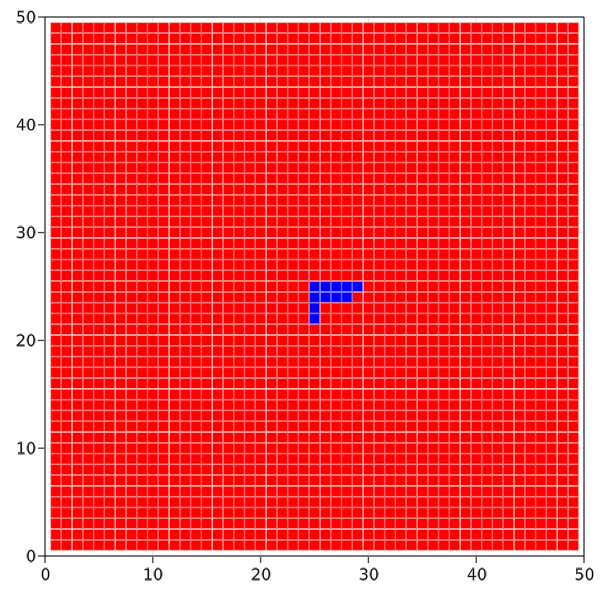

In [7]:
# Setup "Grider"
model = build_model(; dims = (49, 49), properties = Dict(:pay_off_table => PayOffTable(1.7)))
setup_agents(model, 0.0)
get_agent_by_pos(model, (25, 25)).strategy = C
get_agent_by_pos(model, (26, 25)).strategy = C
get_agent_by_pos(model, (27, 25)).strategy = C
get_agent_by_pos(model, (28, 25)).strategy = C
get_agent_by_pos(model, (29, 25)).strategy = C
get_agent_by_pos(model, (25, 24)).strategy = C
get_agent_by_pos(model, (26, 24)).strategy = C
get_agent_by_pos(model, (27, 24)).strategy = C
get_agent_by_pos(model, (28, 24)).strategy = C
get_agent_by_pos(model, (25, 23)).strategy = C
get_agent_by_pos(model, (25, 22)).strategy = C
abm_plot(model, ac = (a -> a.strategy ? :blue : :red), am = '■', as = 10)[1]

We can confirm the grider moves on whenever executing the following 2 lines.

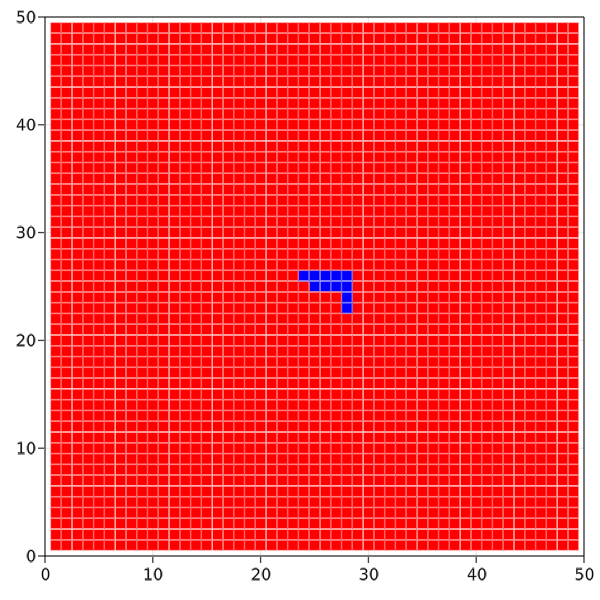

In [8]:
run!(model, dummystep, model_step!, 1)
abm_plot(model, ac = cell_color_simple, am = '■', as = 10)[1]

### 6.1.2. Rotator

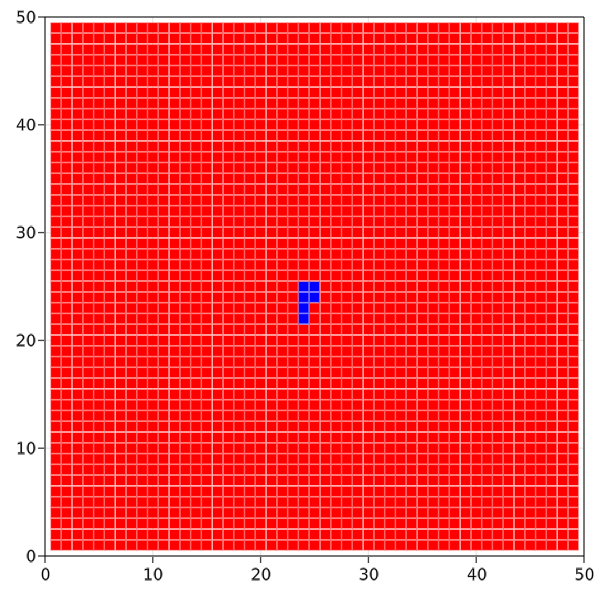

In [9]:
# Setup "Rotator"
model = build_model(; dims = (49, 49), properties = Dict(:pay_off_table => PayOffTable(1.7)))
setup_agents(model, 0.0)
get_agent_by_pos(model, (25, 25)).strategy = C
get_agent_by_pos(model, (24, 25)).strategy = C
get_agent_by_pos(model, (25, 24)).strategy = C
get_agent_by_pos(model, (24, 24)).strategy = C
get_agent_by_pos(model, (24, 23)).strategy = C
get_agent_by_pos(model, (24, 22)).strategy = C
abm_plot(model, ac = (a -> a.strategy ? :blue : :red), am = '■', as = 10)[1]

We can confirm the "Rotator" rotate 90° whenever executing the following 2 lines.

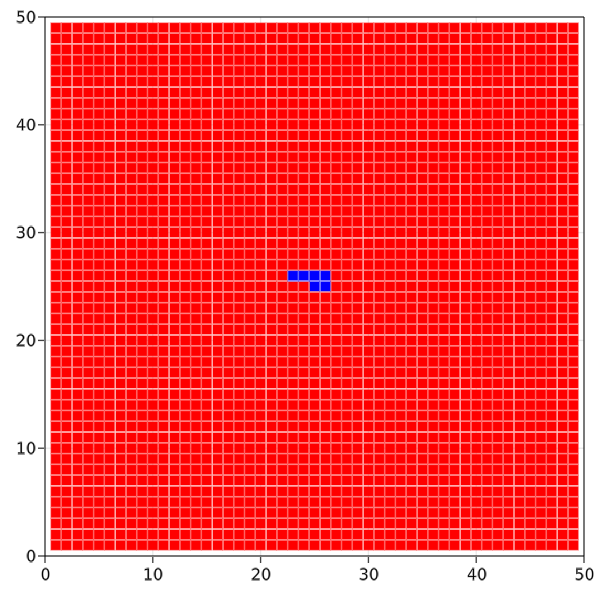

In [10]:
run!(model, dummystep, model_step!, 1)
abm_plot(model, ac = (a -> a.strategy ? :blue : :red), am = '■', as = 10)[1]

## 6.2. The frequency of cooperators

The frequency of cooperators (f_c) in simulations with random or symmetrical initial conditions, within interesting region 1.8 < b < 2.

In both Fig2(a) and Fig2(b), f_c converges at 12 log 2-8 (= 0.318...)!!

### 6.2.1. Fig 2 (a) in [Evolutionary games and spatial chaos (Nowak & May, 1992)](https://www.researchgate.net/publication/216634494_Evolutionary_Games_and_Spatial_Chaos)

The frequency of cooperators, f_c(t), for 300 generations, starting with a random initial configuration of f_c(0) = 0.6.

The simulation is performed on a 400 x 400 square lattice with fixed boundary conditons.

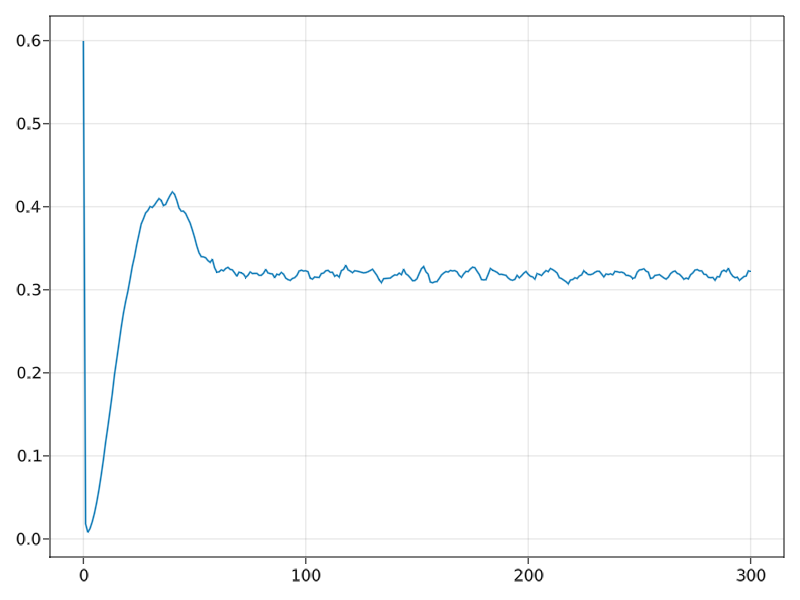

In [11]:
model = build_model(; dims = (400, 400), properties = Dict(:pay_off_table => PayOffTable(1.9)))
setup_agents(model, 0.6)
df, _ = run!(model, dummystep, model_step!, 300; adata = [(:strategy, mean)])
lines(df.step, df.mean_strategy)

### 6.2.2. Fig 2 (b) in [Evolutionary games and spatial chaos (Nowak & May, 1992)](https://www.researchgate.net/publication/216634494_Evolutionary_Games_and_Spatial_Chaos)

The frequency of C within the dynamic fractal generated by a single D invading an infinite array of C.

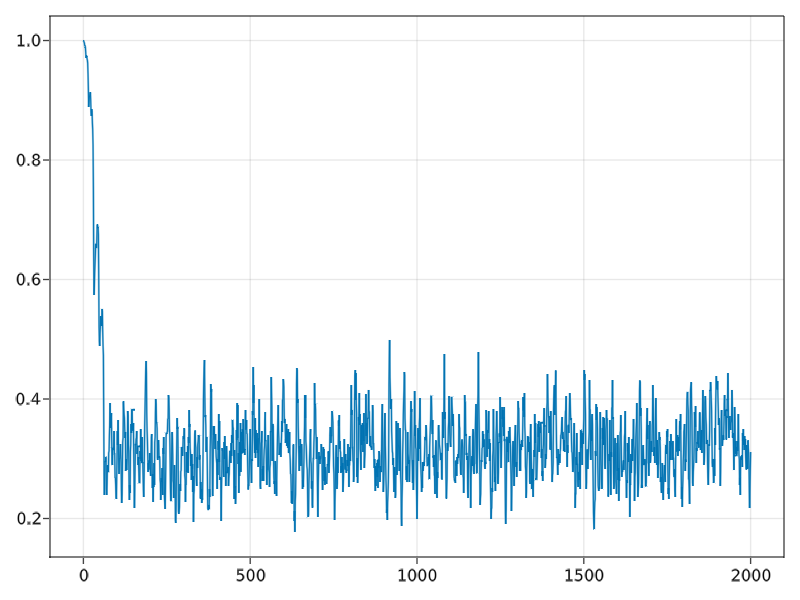

In [12]:
model = build_model(properties = Dict(:pay_off_table => PayOffTable(1.9)))
setup_agents(model, 1.0)
get_agent_by_pos(model, (50, 50)).strategy = D
get_agent_by_pos(model, (50, 50)).prev_strategy = D
df, _ = run!(model, dummystep, model_step!, 2000; adata = [(:strategy, mean)])
lines(df.step, df.mean_strategy)

Not converging. But the mean of f_c is about 12 log 2-8 (= 0.318...).

In [13]:
mean(df.mean_strategy[500:2000])

0.3177502791901272

### 6.3. Kaleidoscope

Enjoy!

In [14]:
# set up 1D in Cs
model = build_model(properties = Dict(:pay_off_table => PayOffTable(1.9)))
setup_agents(model, 1.0)
get_agent_by_pos(model, (50, 50)).strategy = D
get_agent_by_pos(model, (50, 50)).prev_strategy = D

false

### After 30 steps

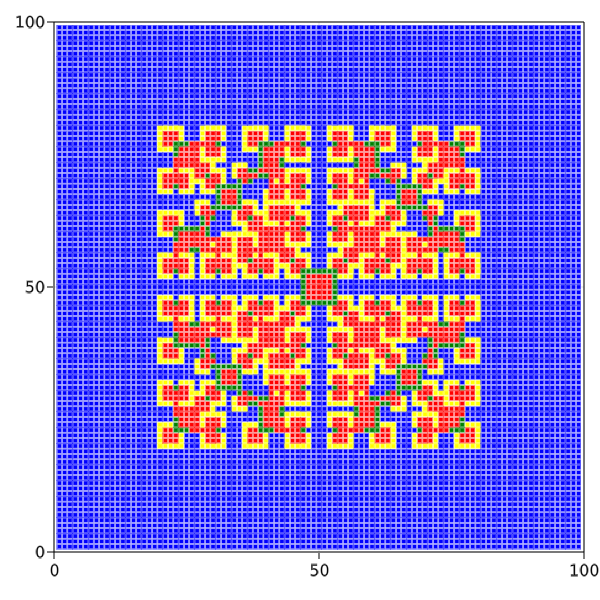

In [15]:
run!(model, dummystep, model_step!, 30)
abm_plot(model, ac = cell_color, am = '■', as = 4)[1]

### After 217 steps

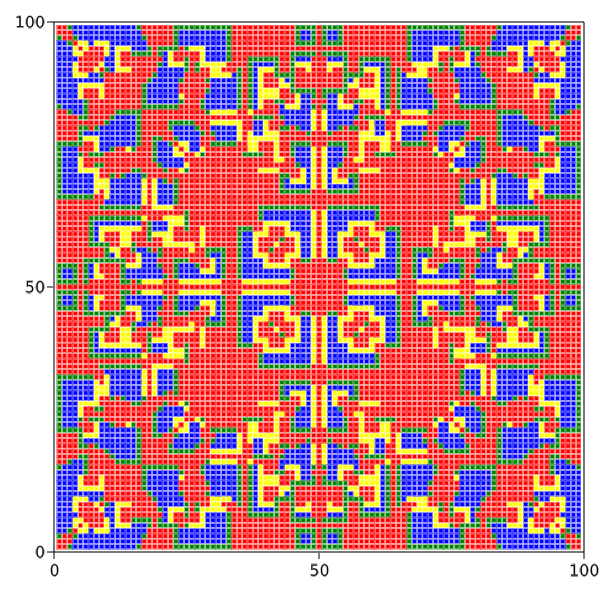

In [16]:
run!(model, dummystep, model_step!, 217 - 30)
abm_plot(model, ac = cell_color, am = '■', as = 4)[1]

### After 219 steps

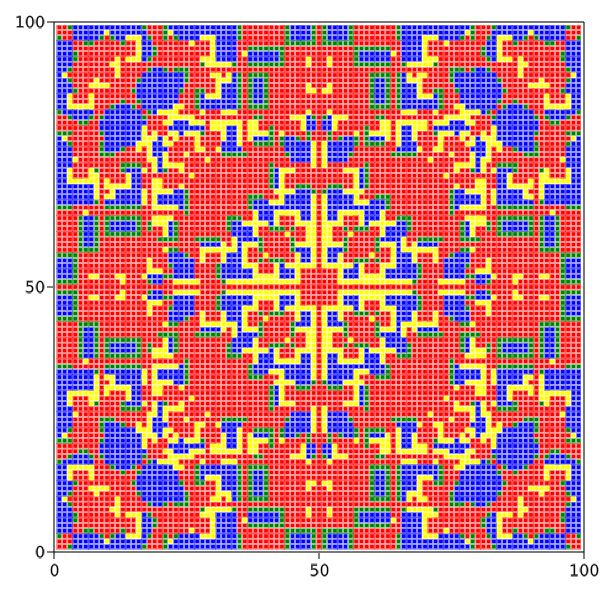

In [17]:
run!(model, dummystep, model_step!, 2)
abm_plot(model, ac = cell_color, am = '■', as = 4)[1]

### After 221 steps

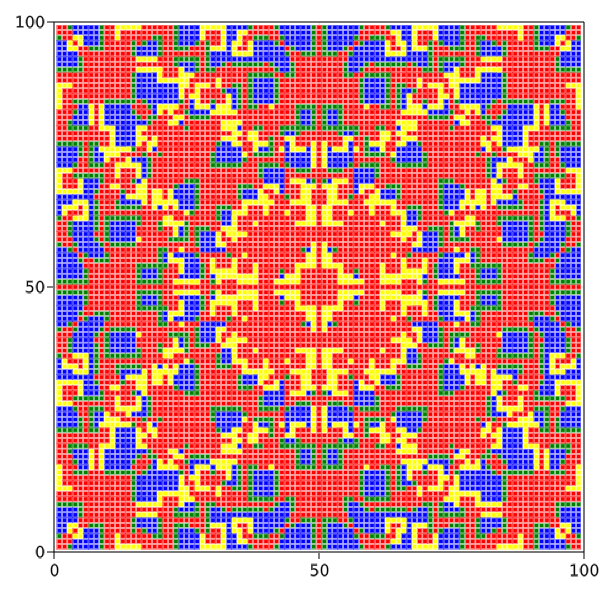

In [18]:
run!(model, dummystep, model_step!, 2)
abm_plot(model, ac = cell_color, am = '■', as = 4)[1]

### Play interactively

In [19]:
model = build_model(properties = Dict(:pay_off_table => PayOffTable(1.85)))
setup_agents(model, 1.0)
get_agent_by_pos(model, (50, 50)).strategy = D
get_agent_by_pos(model, (50, 50)).prev_strategy = D
abm_data_exploration(
    model,
    dummystep,
    model_step!;
    am = '■',
    ac = cell_color,
    as = 5
)

(Scene (1600px, 800px):
  28 Plots:
    ├ MakieCore.Combined{Makie.poly, Tuple{Vector{Vector{GeometryBasics.Point{2, Float32}}}}}
    ├ MakieCore.LineSegments{Tuple{Vector{GeometryBasics.Point{2, Float32}}}}
    ├ MakieCore.LineSegments{Tuple{Vector{GeometryBasics.Point{2, Float32}}}}
    ├ MakieCore.LineSegments{Tuple{Vector{GeometryBasics.Point{2, Float32}}}}
    ├ MakieCore.LineSegments{Tuple{Vector{GeometryBasics.Point{2, Float32}}}}
    ├ MakieCore.LineSegments{Tuple{Vector{GeometryBasics.Point{2, Float32}}}}
    ├ MakieCore.LineSegments{Tuple{Vector{GeometryBasics.Point{2, Float32}}}}
    ├ MakieCore.Combined{Makie.annotations, Tuple{Vector{Tuple{String, GeometryBasics.Point{2, Float32}}}}}
    ├ MakieCore.Text{Tuple{String}}
    ├ MakieCore.Lines{Tuple{Vector{GeometryBasics.Point{2, Float32}}}}
    ├ MakieCore.LineSegments{Tuple{Vector{GeometryBasics.Point{2, Float32}}}}
    ├ MakieCore.LineSegments{Tuple{Vector{GeometryBasics.Point{2, Float32}}}}
    ├ MakieCore.Combined{Makie.